In [1]:
##### MODELING LIBRARIES #####
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping
# from sklearn.linear_model import LassoCV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from patsy import dmatrices, dmatrix

from sklearn.metrics import accuracy_score

##### FORMATTING AND GRAPHING LIBRARIES #####
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##### TIMING AND UTILITY LIBRARIES #####
import sqlalchemy as db
from datetime import datetime
import timeit
from dateutil.relativedelta import relativedelta 
import random

In [2]:
##### IMPORT PREPARED DATA #####
print('Reading pre-built dataset...')
df_load = pd.read_csv('../PJM_Weekly_Model/sample_base_data.csv', index_col = 0, parse_dates = [0])

# Drop all lag columns for us in RNN
lag_sq_cols = [column for column in df_load.columns if 'Lag' in column or 'Sq' in column]
df_load = df_load.drop(columns = lag_sq_cols)

# Drop null rows - should only be losing daylight savings in March
dropped = df_load.shape[0] - df_load.dropna().shape[0]
print('Dropping %s null values...'%(dropped))
df_load = df_load.dropna()

# Convert date, time, holiday columns to categorical variables
for col in ['Month','WeekDay','Day','Hour']:
    df_load[col] = df_load[col].astype('category')

Reading pre-built dataset...
Dropping 1 null values...


In [3]:
df_load.head()

,value,WWP,THI,Light,Month,Day,WeekDay,Hour,Holiday
Date,,,,,,,,,
2016-12-31 00:00:00,91396.152,31.818182,32.369474,0.0,12,31,6,0,0
2016-12-31 01:00:00,87452.797,31.489916,32.000000,0.0,12,31,6,1,0
2016-12-31 02:00:00,85229.439,31.449558,31.535789,0.0,12,31,6,2,0
2016-12-31 03:00:00,84076.640,31.310316,31.310316,0.0,12,31,6,3,0
2016-12-31 04:00:00,83792.683,30.891705,31.166316,0.0,12,31,6,4,0


In [4]:
##### FINAL DATA PREPARATION #####
print("\nDefining testing and training set...") 

# Set random seed
random.seed(238)

# Use Patsy to create the one-hot encoded dummy variables with interactions 
y, X =  dmatrices('value~Light+WWP+THI+Month+Day+WeekDay+Hour+Holiday',df_load,return_type='dataframe')

# Split data into training and testing data sets with two-year training sample (8760 h/yr * 2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 17520 / X.shape[0], shuffle = False)

# Standardize both datasets - create fit to use on backcast dataset
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)


Defining testing and training set...


In [5]:
##### RNN MODEL #####
tic = timeit.default_timer()
print("\nBuilding and training model...") 

# Create training sequences
train_sequences = TimeseriesGenerator(X_train_ss, y_train['value'], length = 48, batch_size = 512)

# Create test sequences
test_sequences = TimeseriesGenerator(X_test_ss, y_test['value'], length = 48, batch_size = 512)

model = Sequential()
model.add(GRU(128, input_shape = (48,75), return_sequences = True, activation = 'relu'))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences = True, activation = 'relu'))
model.add(Dropout(0.2))
model.add(GRU(32, return_sequences = True, activation = 'relu'))
model.add(Dropout(0.2))
model.add(GRU(16, return_sequences = False, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mean_squared_error', metrics = 'mean_absolute_percentage_error')

history = model.fit(train_sequences, validation_data = test_sequences, epochs = 10)

toc = timeit.default_timer()
print('RNN fit created in %0.2f seconds' % (toc-tic))


Building and training model...
Epoch 1/10
35/35 [==============================] - 11s 310ms/step - loss: 9300726784.0000 - mean_absolute_percentage_error: 99.3677 - val_loss: 23365294080.0000 - val_mean_absolute_percentage_error: 161.5683
Epoch 2/10
35/35 [==============================] - 10s 299ms/step - loss: 8065883648.0000 - mean_absolute_percentage_error: 66.3152 - val_loss: 2223727616.0000 - val_mean_absolute_percentage_error: 44.6019
Epoch 3/10
35/35 [==============================] - 11s 300ms/step - loss: 2124594816.0000 - mean_absolute_percentage_error: 42.1523 - val_loss: 1570292992.0000 - val_mean_absolute_percentage_error: 35.1917
Epoch 4/10
35/35 [==============================] - 11s 304ms/step - loss: 2046248960.0000 - mean_absolute_percentage_error: 41.3016 - val_loss: 3376951296.0000 - val_mean_absolute_percentage_error: 59.3277
Epoch 5/10
35/35 [==============================] - 10s 298ms/step - loss: 2265003264.0000 - mean_absolute_percentage_error: 43.5251 - val

In [8]:
history.history['val_loss'][-1]

2358523136.0

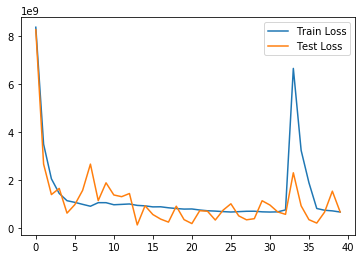

In [63]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Test Loss')
plt.legend();

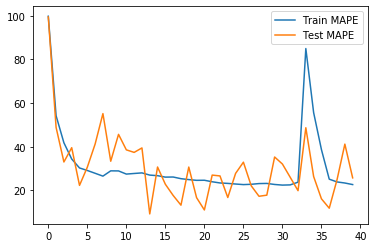

In [64]:
plt.plot(history.history['mean_absolute_percentage_error'], label = 'Train MAPE')
plt.plot(history.history['val_mean_absolute_percentage_error'], label = 'Test MAPE')
plt.legend();

In [65]:
y_train['predicted'] = np.append([np.NaN] * 48, model.predict(train_sequences).transpose())

C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
y_test['predicted'] = np.append([np.NaN] * 48, model.predict(test_sequences).transpose())

C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


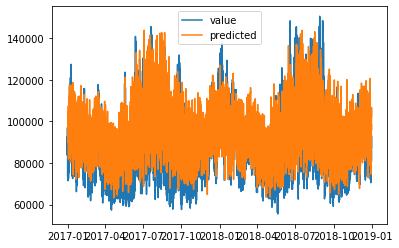

In [61]:
plt.plot(y_train)
plt.legend(y_train.columns)

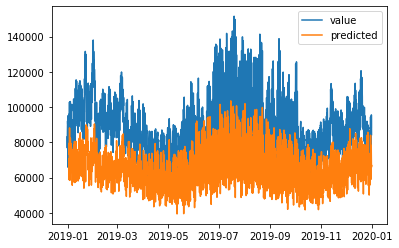

In [68]:
plt.plot(y_test)
plt.legend(y_test.columns)

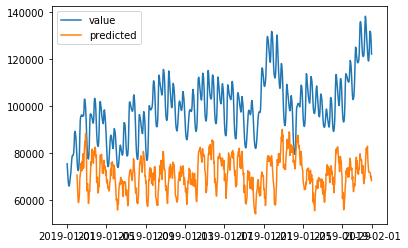

In [69]:
plt.plot(y_test['2019-01'])
plt.legend(y_test.columns)

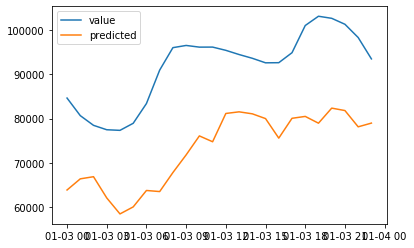

In [70]:
plt.plot(y_test['20190103'])
plt.legend(y_test.columns)